# Split datasets


In [12]:
import json
import os
import shutil
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [127]:
seed = 19
split_ratio_1 = 0.2  # (validation+test) / (train+validation+test)
split_ratio_2 = 0.5  # (test) / (validation+test)

# label_map_csv = "../datasets/cassava-leaf-disease-classification/train.csv"

label_map_csv = "../datasets/ddi-diverse-dermatology-images/ddi_metadata.csv"
images_root = "../datasets/ddi-diverse-dermatology-images/"
# target_column = "disease"
target_column = "malignant"
file_column = "DDI_file"
image_type = ""

label_map_csv = "../datasets/HAM10000/HAM10000_metadata"
images_root = "../datasets/HAM10000/images/"
target_column = "dx"
file_column = "image_id"
image_type = ".jpg"


label_map_csv = "../datasets/fitzpatrick17k/fitzpatrick17k.csv"
images_root = "../datasets/fitzpatrick17k/images/"
# target_column = "nine_partition_label"
target_column = "three_partition_label"
file_column = "url"
image_type = ""

label_map_csv = "../datasets/PAD-UFES-20/metadata.csv"
images_root = "../datasets/PAD-UFES-20/images/"
target_column = "diagnostic"
file_column = "img_id"
image_type = ""
group_columns = ["patient_id"]  # , "lesion_id"

In [4]:
df_full = pd.read_csv(label_map_csv)
df_full.columns

Index(['patient_id', 'lesion_id', 'smoke', 'drink', 'background_father',
       'background_mother', 'age', 'pesticide', 'gender',
       'skin_cancer_history', 'cancer_history', 'has_piped_water',
       'has_sewage_system', 'fitspatrick', 'region', 'diameter_1',
       'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed',
       'elevation', 'img_id', 'biopsed'],
      dtype='object')

In [7]:
if "url" in df_full.columns:
    for image_url in df_full["url"]:
        file_name = None
        if str(image_url) == "nan":
            # print(f"image_url: {image_url}")
            # print(f"file_name: {file_name}")
            continue
        elif str(image_url).startswith("https://www.dermaamin.com"):
            continue
        elif str(image_url).startswith("http://atlasdermatologico.com.br/img"):
            continue

        file_name = os.path.basename(image_url)
        file_name = file_name.replace("?", "")
        file_path = os.path.join(images_root, file_name)

        if not os.path.exists(file_path):
            response = requests.get(
                image_url, stream=True, headers={"User-Agent": "XY"}
            )
            if not response.ok:
                print(f"image_url: {image_url}")
                print(response)
                continue

            with open(file_path, "wb") as handle:
                for block in response.iter_content(1024):
                    if not block:
                        break
                    handle.write(block)
else:
    print("Skip download")

Skip download


In [85]:
groups = df_full.groupby(group_columns)
for name, group in groups:
    sub_groups = group.groupby(target_column)
    for sub_name, sub_group in sub_groups:
        # print(f"{name}: {sub_name}")
        if 1 < len(sub_groups):
            print(group)

In [9]:
for value in df_full[target_column].unique():
    subdirectory = os.path.join(images_root, target_column, str(value))
    print(f"Copying to {subdirectory}")
    os.makedirs(subdirectory, exist_ok=True)
    for image_path in df_full[df_full[target_column] == value][file_column]:
        if str(image_path) == "nan":
            continue

        image_name = os.path.basename(image_path)
        image_name = image_name.replace("?", "")
        image_name += image_type
        source_path = os.path.join(images_root, image_name)

        if os.path.exists(source_path):
            shutil.copy(source_path, f"{subdirectory}/")
        else:
            print(f"Missing file: {source_path}")

Copying to ../datasets/PAD-UFES-20/images/diagnostic\NEV
Copying to ../datasets/PAD-UFES-20/images/diagnostic\BCC
Copying to ../datasets/PAD-UFES-20/images/diagnostic\ACK
Copying to ../datasets/PAD-UFES-20/images/diagnostic\SEK
Copying to ../datasets/PAD-UFES-20/images/diagnostic\SCC
Copying to ../datasets/PAD-UFES-20/images/diagnostic\MEL


In [161]:
groups = df_full.groupby(group_columns)
group_ids = list(groups.groups.keys())

train_ids, valid_test_ids = train_test_split(
    group_ids,
    test_size=split_ratio_1,
    random_state=seed,
)

valid_ids, test_ids = train_test_split(
    valid_test_ids,
    test_size=split_ratio_2,
    random_state=seed,
)


def get_set(values):
    group_id = tuple(values)
    if 1 == len(group_id):
        group_id = group_id[0]

    if group_id in train_ids:
        return "train"
    elif group_id in valid_ids:
        return "valid"
    elif group_id in test_ids:
        return "test"
    else:
        print(f"group_id: {group_id}")
        return None


df_split = df_full[[target_column, file_column]].copy()
df_split.columns = ["target_code", "filename"]
df_split["set"] = df_full[group_columns].apply(get_set, axis=1)

In [162]:
df_test = df_split[df_split["set"] == "train"]
df_test.groupby("target_code")["filename"].count() / len(df_test)

target
ACK    593
BCC    657
MEL     40
NEV    198
SCC    137
SEK    191
Name: file, dtype: int64

In [163]:
df_valid = df_split[df_split["set"] == "valid"]
df_valid.groupby("target_code")["filename"].count() / len(df_valid)

target
ACK    0.253846
BCC    0.423077
MEL    0.030769
NEV    0.096154
SCC    0.107692
SEK    0.088462
Name: file, dtype: float64

In [164]:
df_test = df_split[df_split["set"] == "test"]
df_test.groupby("target_code")["filename"].count() / len(df_test)

target
ACK    0.319820
BCC    0.351351
MEL    0.018018
NEV    0.094595
SCC    0.121622
SEK    0.094595
Name: file, dtype: float64

In [ ]:
# TODO: implement stratify

# df_train, df_valid_test = train_test_split(
#     df_full,
#     test_size=split_ratio_1,
#     stratify=df_full[target_column],
#     random_state=seed,
# )
# df_valid, df_test = train_test_split(
#     df_valid_test,
#     test_size=split_ratio_2,
#     stratify=df_valid_test[target_column],
#     random_state=seed,
# )

In [165]:
df_split.to_csv(os.path.join(images_root, target_column, "split.csv"))

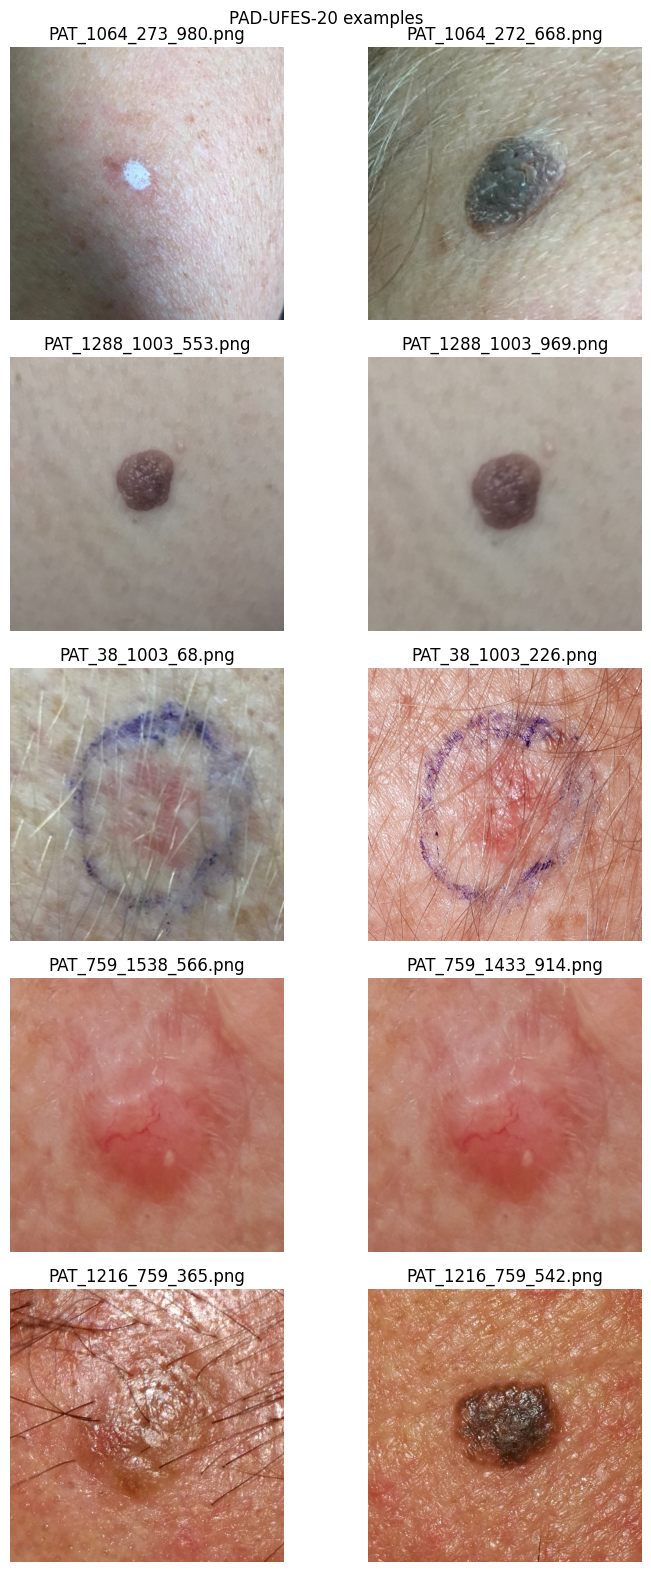

In [84]:
# NOTE: grouping patient_id can be problematic. Examples:
# PAT_1064_272_668, PAT_1064_273_980
# PAT_759_1538_566, PAT_759_1433_914
# PAT_1216_759_365, PAT_1216_759_542

# Different lesions should not get mixed up
# Sometimes different lesions have the same image


# <patient_id>_<lesion_id>_<image_number>.png
image_paths = [
    [
        "../datasets/PAD-UFES-20/images/PAT_1064_273_980.png",
        "../datasets/PAD-UFES-20/images/PAT_1064_272_668.png",
    ],
    [
        "../datasets/PAD-UFES-20/images/PAT_1288_1003_553.png",
        "../datasets/PAD-UFES-20/images/PAT_1288_1003_969.png",
    ],
    [
        "../datasets/PAD-UFES-20/images/PAT_38_1003_68.png",
        "../datasets/PAD-UFES-20/images/PAT_38_1003_226.png",
    ],
    [
        "../datasets/PAD-UFES-20/images/PAT_759_1538_566.png",
        "../datasets/PAD-UFES-20/images/PAT_759_1433_914.png",
    ],
    [
        "../datasets/PAD-UFES-20/images/PAT_1216_759_365.png",
        "../datasets/PAD-UFES-20/images/PAT_1216_759_542.png",
    ],
]

fig, ax = plt.subplots(
    len(image_paths),
    len(image_paths[0]),
    figsize=(8, 16),
)

fig.suptitle("PAD-UFES-20 examples")
for row in range(len(image_paths)):
    for column in range(len(image_paths[0])):
        image_path = image_paths[row][column]
        pil_im = Image.open(image_path, "r")
        title = os.path.basename(image_path)
        ax[row][column].imshow(pil_im)
        ax[row][column].set_title(title)
        ax[row][column].axis("off")

fig.tight_layout()
plt.show()

In [25]:
# df_train, df_test = train_test_split(
#     df_full, test_size=test_ratio, stratify=df_full["label"], random_state=seed
# )
# print(df_train["label"].value_counts())
# print(df_test["label"].value_counts())

# _, df_train_mini = train_test_split(
#     df_train, test_size=0.1, stratify=df_train["label"], random_state=seed
# )
# print(df_train_mini["label"].value_counts())

In [26]:
# entries = json.load(
#     open(
#         "../datasets/cassava-leaf-disease-classification/label_num_to_disease_map.json"
#     )
# )
# entries

In [27]:
# for key in entries:
#     value = entries[key]
#     os.makedirs(f"../datasets/cassava-dataset/train/{value}/", exist_ok=True)
#     os.makedirs(f"../datasets/cassava-dataset/test/{value}/", exist_ok=True)
#     os.makedirs(f"../datasets/cassava-dataset/train-mini/{value}/", exist_ok=True)

In [28]:
# for index, row in df_test.iterrows():
#     image_id = row["image_id"]
#     label_key = row["label"]
#     shutil.copy(
#         f"../datasets/cassava-leaf-disease-classification/train_images/{image_id}",
#         f"../datasets/cassava-dataset/test/{entries[str(label_key)]}/"
#     )

In [29]:
# for index, row in df_train.iterrows():
#     image_id = row["image_id"]
#     label_key = row["label"]
#     shutil.copy(
#         f"../datasets/cassava-leaf-disease-classification/train_images/{image_id}",
#         f"../datasets/cassava-dataset/train/{entries[str(label_key)]}/"
#     )

In [30]:
# for index, row in df_train_mini.iterrows():
#     image_id = row["image_id"]
#     label_key = row["label"]
#     shutil.copy(
#         f"../datasets/cassava-leaf-disease-classification/train_images/{image_id}",
#         f"../datasets/cassava-dataset/train-mini/{entries[str(label_key)]}/"
#     )